In [59]:
import os
import json
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
import matplotlib.pylab as plt
from Useful_Functions import industry_identifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [38]:
SBA_Loan = pd.read_csv('SBAnational.csv', low_memory=False)
NAICS_DF = pd.read_csv('General Industry Codes.csv')
NAICS_DF = NAICS_DF.set_index('Code')

In [40]:
NAICS_DF

,IndustryName
Code,
11,"Agriculture, forestry, fishing and hunting"
21,"Mining, quarrying, and oil and gas extraction"
22,Utilities
23,Construction
31,Manufacturing
32,Manufacturing
33,Manufacturing
41,Wholesale trade
42,Wholesale trade


In [81]:
#----------------Overview of the Dataframe
#print(SBA_Loan.info())
print(SBA_Loan['NAICS'].value_counts()[0]/SBA_Loan.shape[0])   #about 22.5% of data do not have industry info, they can be removed for some questions
print(SBA_Loan['Term'].value_counts()[0]/SBA_Loan.shape[0])    #about 0.1% of data have 0 term, which makes no sense, since the term is in months, it is likely that the loan duration is less than 1 month (e.g., 1 week), in this case 0 should be round up to 1
print(SBA_Loan['State'].value_counts(dropna = False)[-1]/SBA_Loan.shape[0]) # only a few entries done have state info, we can drop them
print(SBA_Loan['Name'].value_counts(dropna = False)[-1]/SBA_Loan.shape[0]) # only a few entries done have name info, we can drop them
SBA_Loan = SBA_Loan[SBA_Loan['State'].notna()]
SBA_Loan = SBA_Loan[SBA_Loan['Name'].notna()]
SBA_Loan['Name'] = SBA_Loan['Name'].astype(str)

0.22459227525090752
0.0009008648302370276
0.0017939444088547227
1.1121788027617625e-06


In [82]:
#Fill Missing values in the Industry Column, option 1: fill it with the most popular industry in that state
#step 1 Append General Industry to dataframe, and create a list of all states
No_missing_industry_df = SBA_Loan[SBA_Loan['NAICS'] != 0]
No_missing_industry_df['Industry'] = SBA_Loan['NAICS']
No_missing_industry_df['Industry'] = No_missing_industry_df['Industry'].apply(lambda x: industry_identifier(x,NAICS_DF))

States_list = No_missing_industry_df['State'].unique().tolist()

<ipython-input-82-0d2b2b25632b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  No_missing_industry_df['Industry'] = SBA_Loan['NAICS']
<ipython-input-82-0d2b2b25632b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  No_missing_industry_df['Industry'] = No_missing_industry_df['Industry'].apply(lambda x: industry_identifier(x,NAICS_DF))


In [83]:
No_missing_industry_df.head(100)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00",Retail trade
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00",Accommodation and food services
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00",Health care and social assistance
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,28-Feb-97,1997,...,N,NaN,30-Jun-97,"$517,000.00",$0.00,P I F,$0.00,"$517,000.00","$387,750.00",Manufacturing
7,1000094005,WEAVER PRODUCTS,SUMMERFIELD,FL,34491,REGIONS BANK,AL,811118,28-Feb-97,1997,...,Y,NaN,30-Jun-98,"$45,000.00",$0.00,P I F,$0.00,"$45,000.00","$36,000.00",Other services (except public administration)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,1001494009,THE SPORTS SECTION OF THE N.S.,NEWBURYPORT,MA,1950,DANVERSBANK,MA,541921,28-Feb-97,1997,...,Y,NaN,31-Mar-97,"$31,000.00",$0.00,P I F,$0.00,"$31,000.00","$24,800.00","Professional, scientific and technical services"
188,1001506002,TRIPLE J EXCAVATION,LAS CRUCES,NM,88012,COMPASS BANK,TX,238190,7-Feb-06,2006,...,N,NaN,28-Feb-06,"$50,000.00",$0.00,P I F,$0.00,"$50,000.00","$25,000.00",Construction
189,1001515009,"A. DeSousa, Inc.",Berkley,MA,2779,BANK OF AMERICA NATL ASSOC,NC,235510,8-Jul-97,1997,...,N,NaN,31-May-98,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$20,000.00",Construction
192,1001535004,Classic Plumbing & Heating Con,Cambridge,MA,2141,BANK OF AMERICA NATL ASSOC,NC,235110,10-Jul-97,1997,...,N,NaN,31-Oct-97,"$50,000.00",$0.00,P I F,$0.00,"$50,000.00","$25,000.00",Construction


'Retail trade'

In [84]:
States_list # ok

['IN',
 'CT',
 'FL',
 'NC',
 'IL',
 'OK',
 'AR',
 'MN',
 'CA',
 'SC',
 'TX',
 'LA',
 'IA',
 'TN',
 'MS',
 'OH',
 'MD',
 'VA',
 'MA',
 'PA',
 'OR',
 'ME',
 'KS',
 'MI',
 'AK',
 'WA',
 'CO',
 'WY',
 'UT',
 'MO',
 'AZ',
 'ID',
 'RI',
 'NJ',
 'NH',
 'NM',
 'NV',
 'NY',
 'ND',
 'VT',
 'WI',
 'MT',
 'AL',
 'GA',
 'KY',
 'NE',
 'WV',
 'SD',
 'DE',
 'DC',
 'HI']

<ipython-input-61-769ef71bf501>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


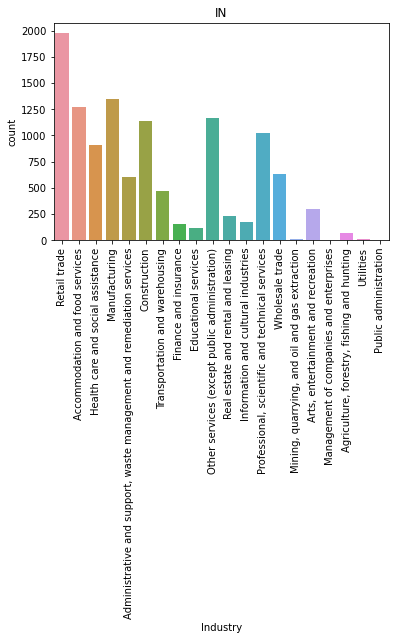

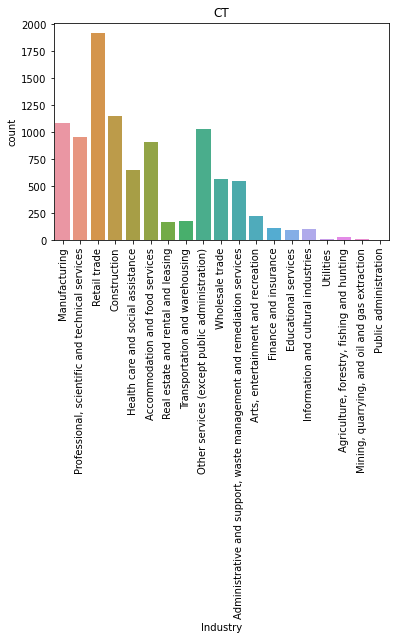

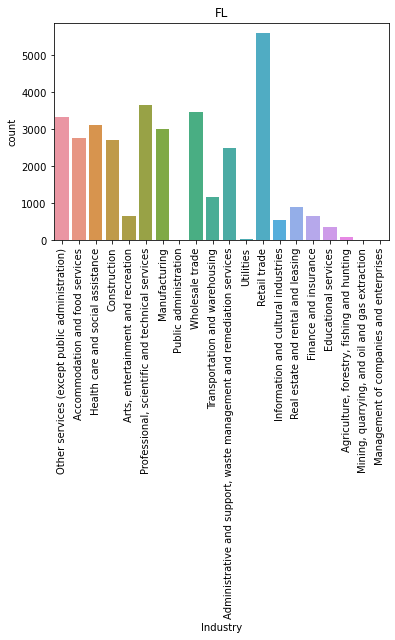

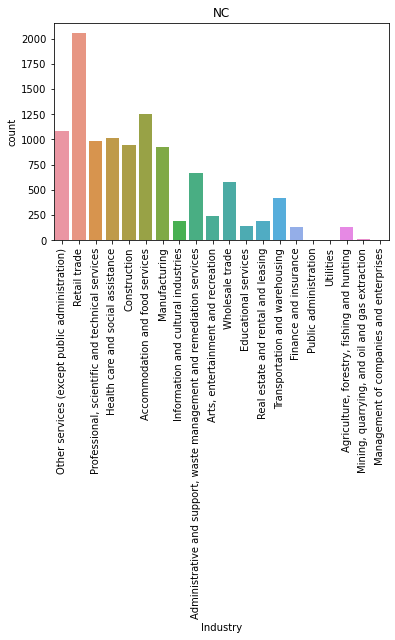

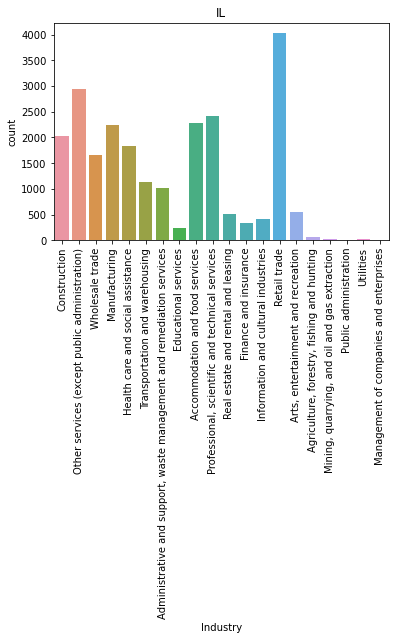

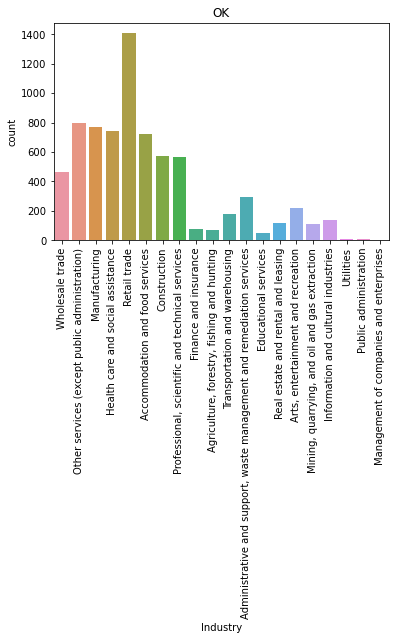

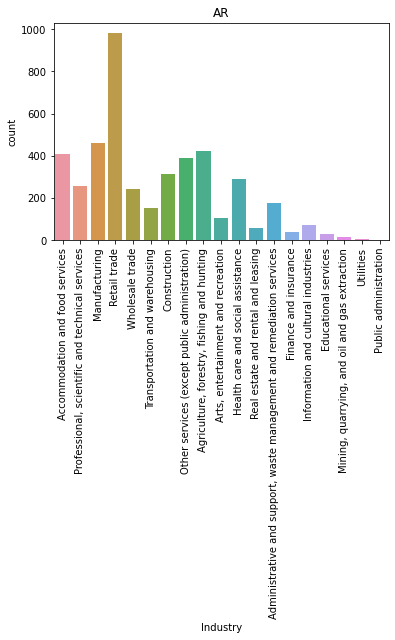

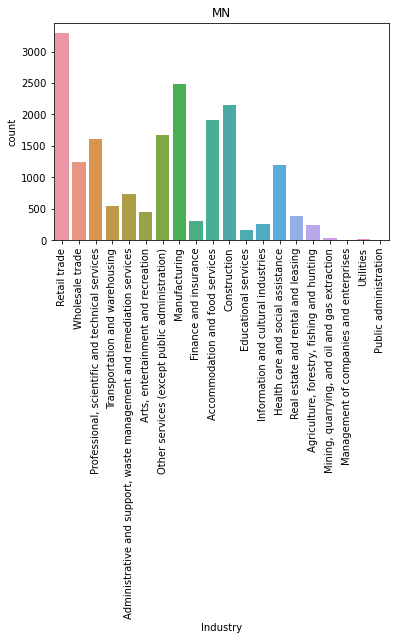

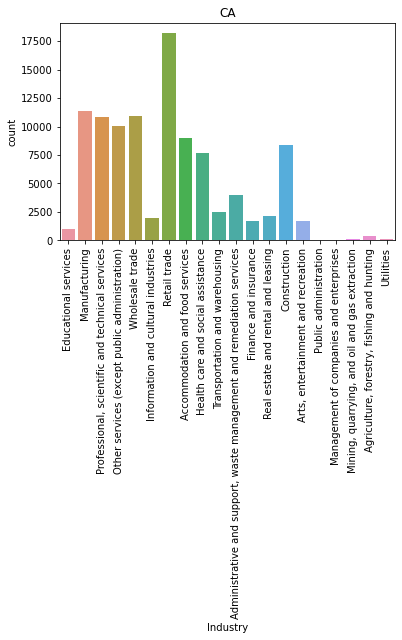

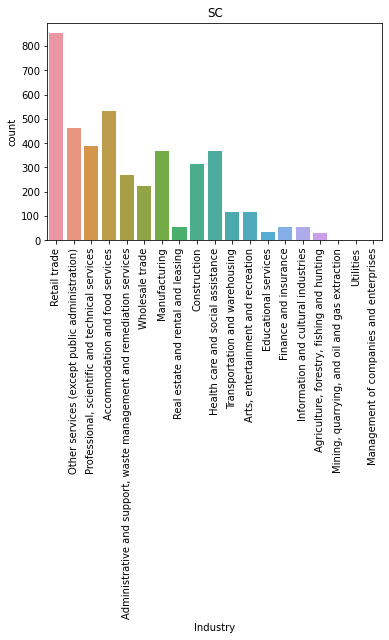

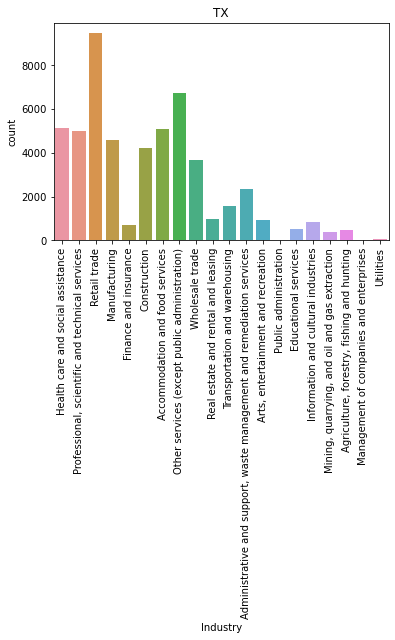

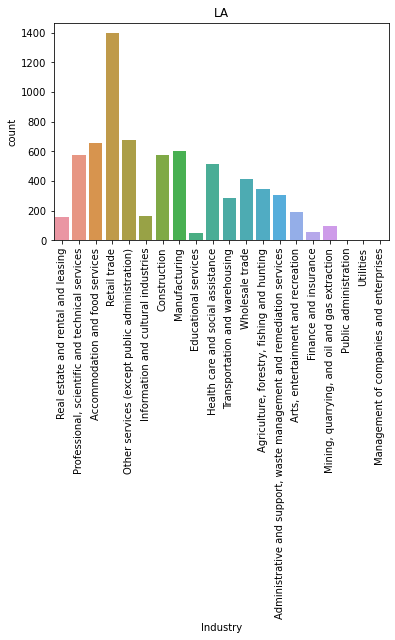

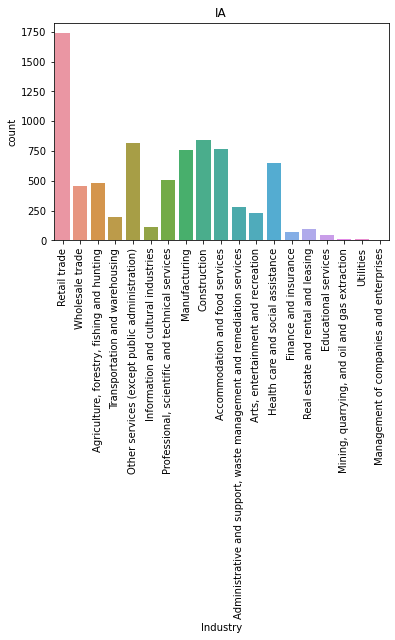

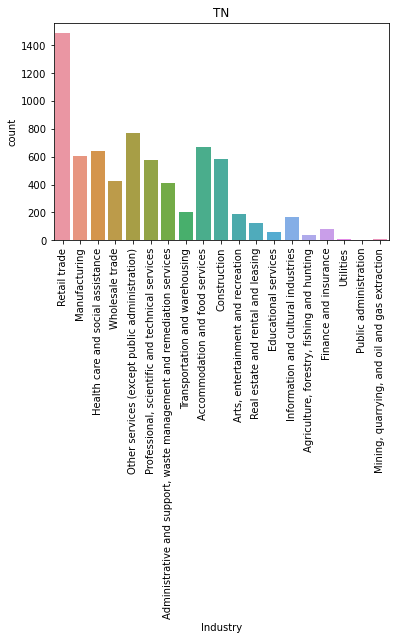

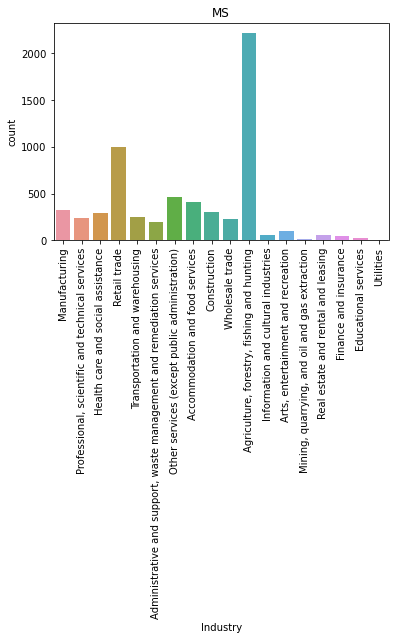

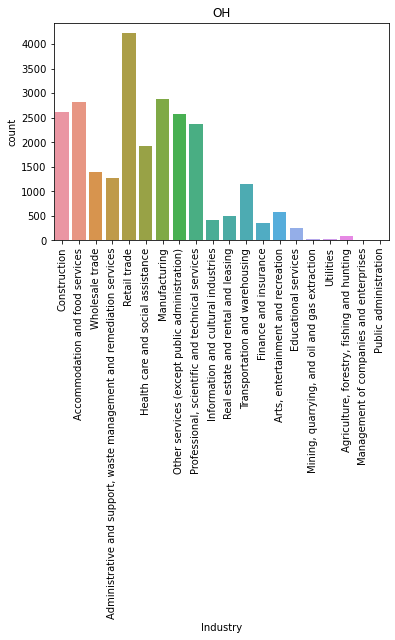

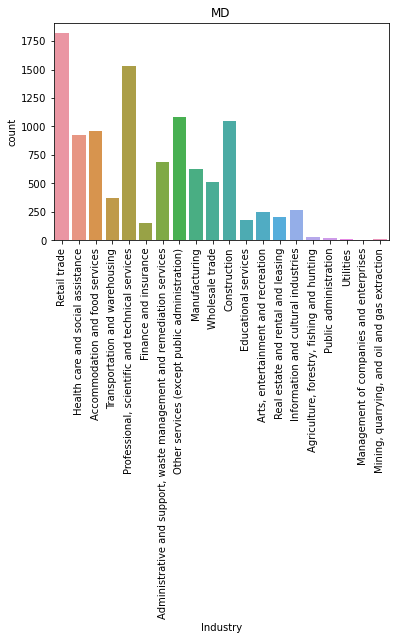

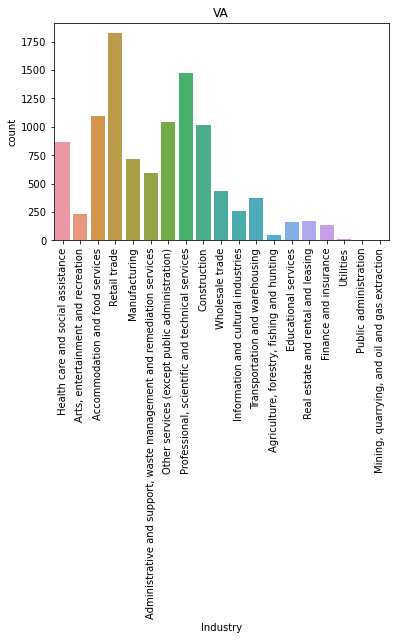

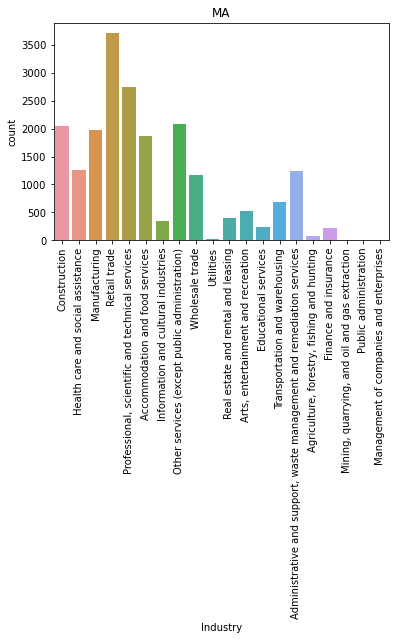

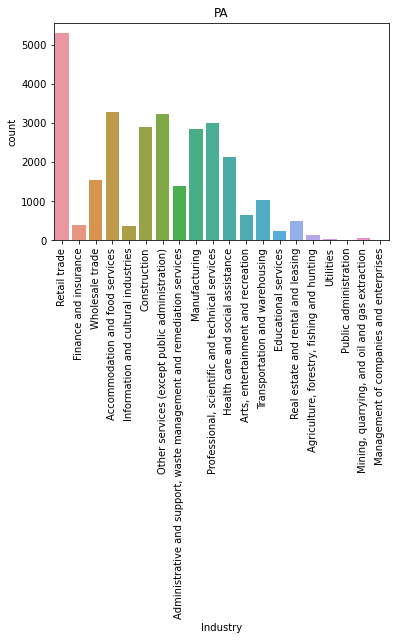

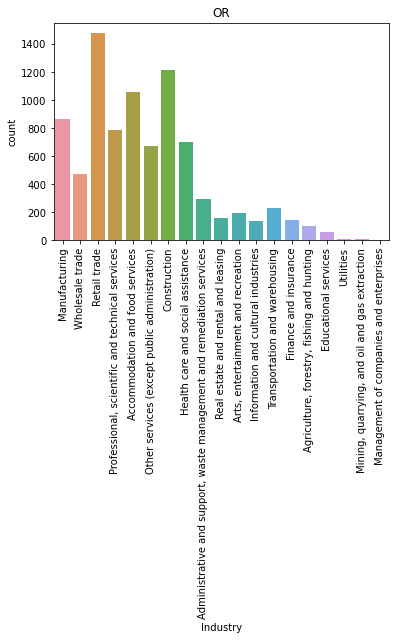

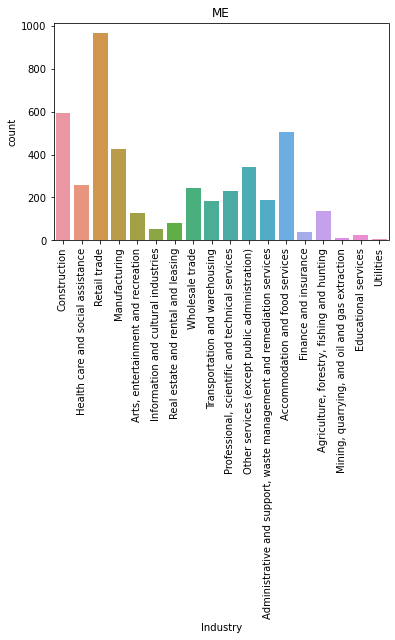

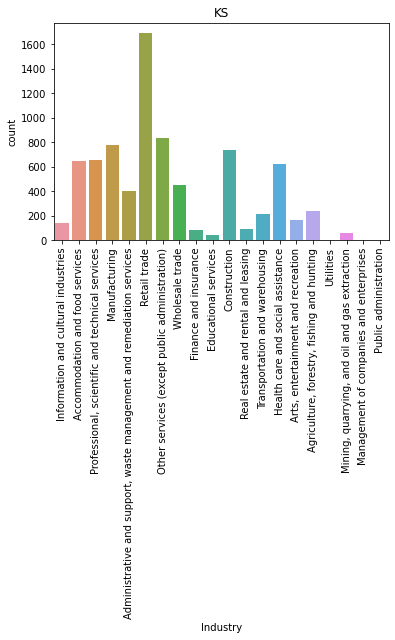

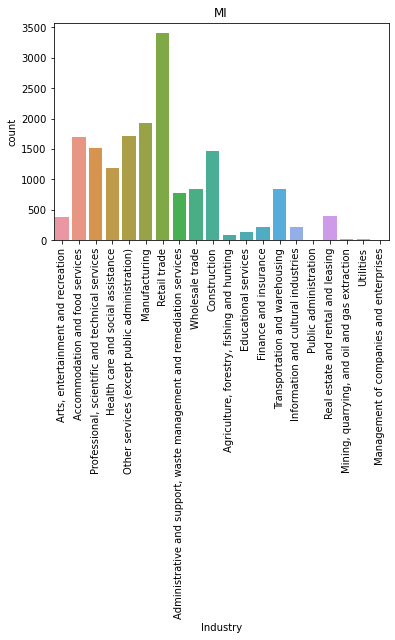

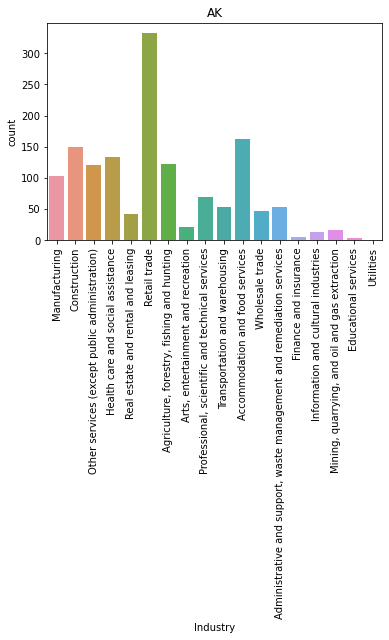

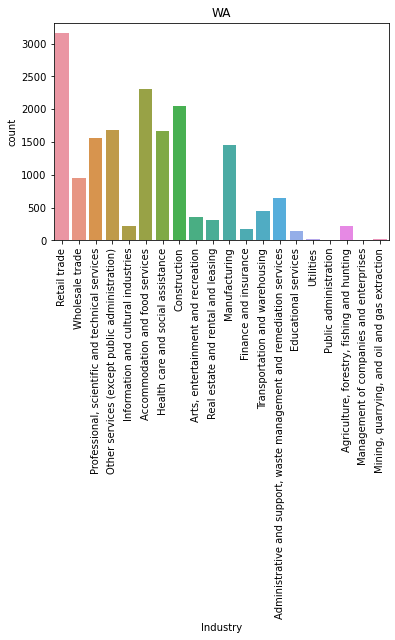

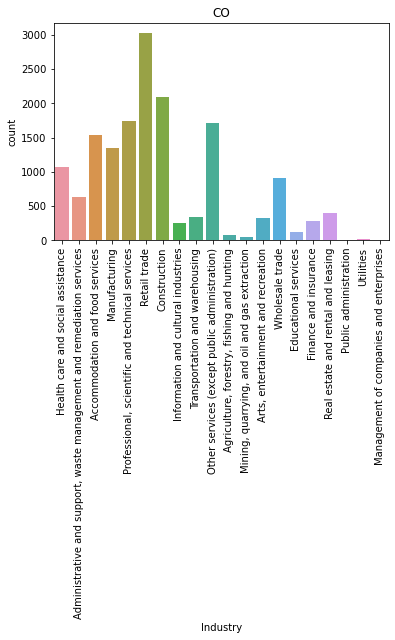

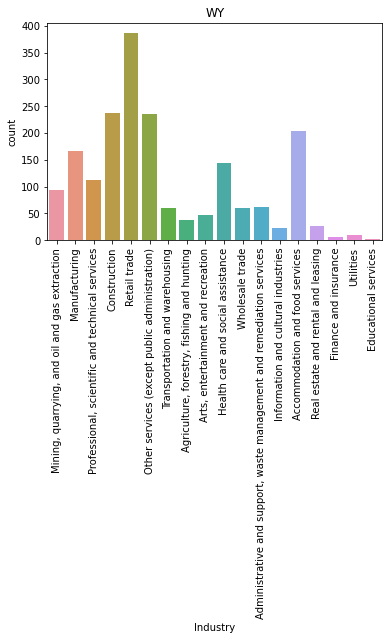

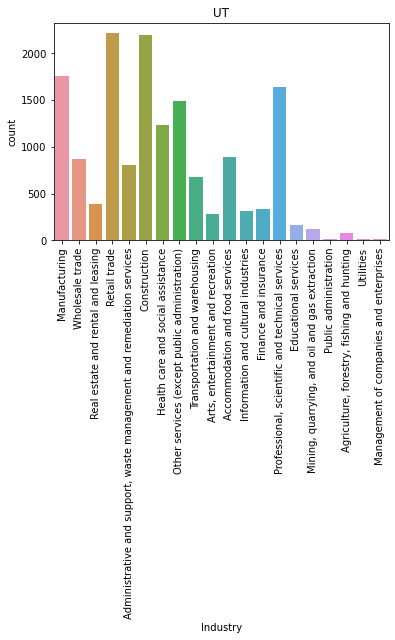

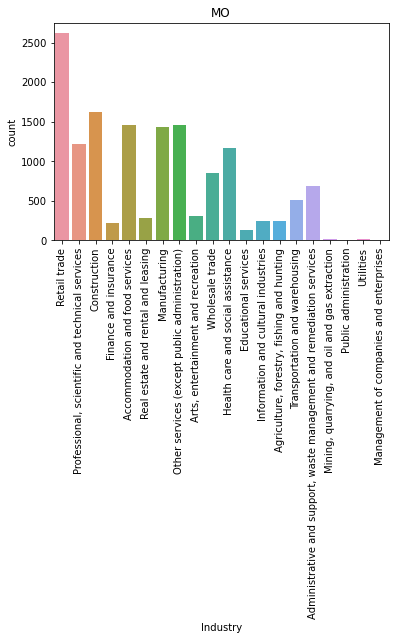

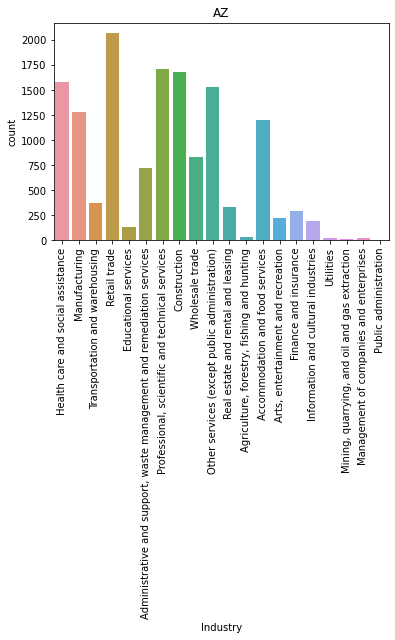

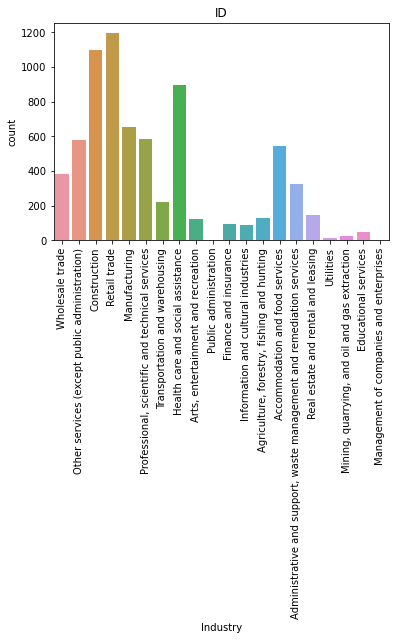

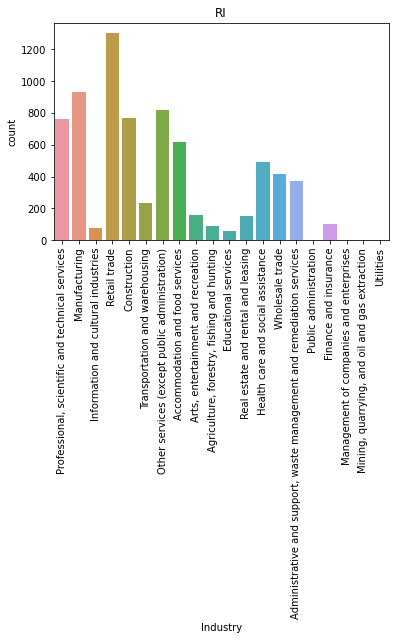

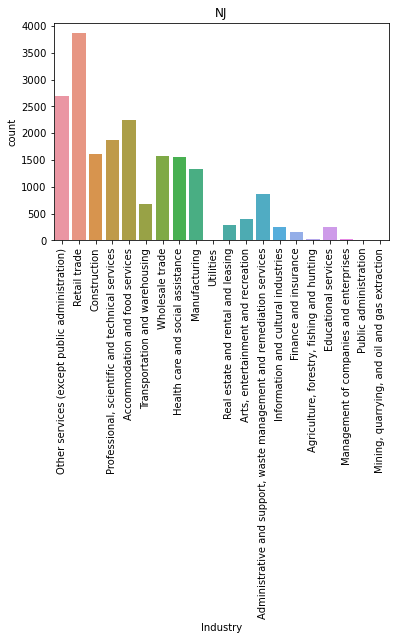

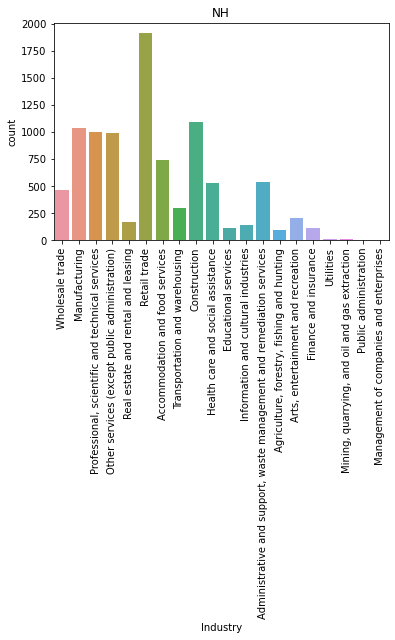

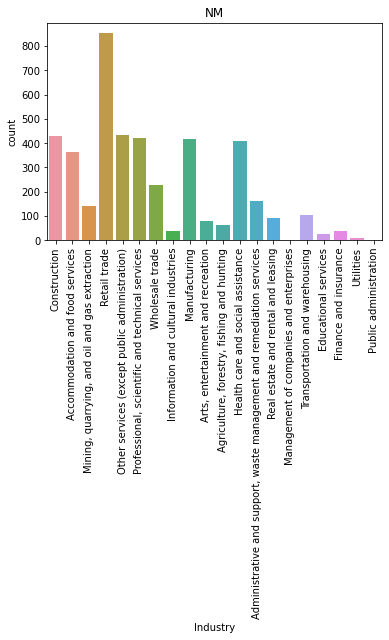

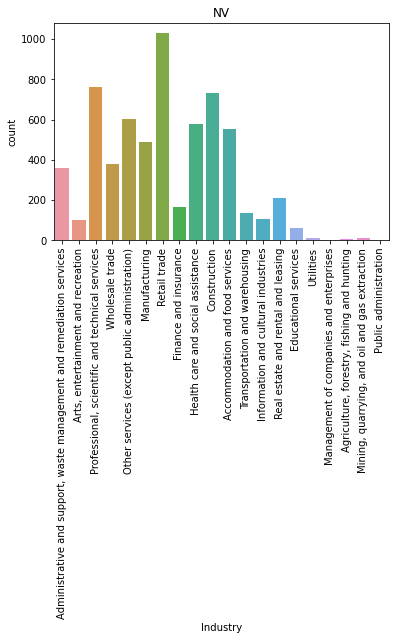

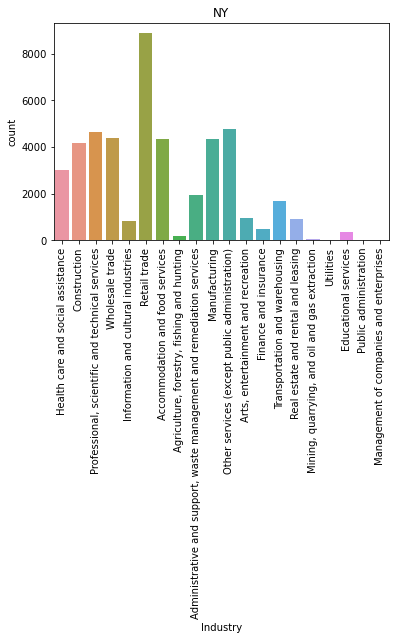

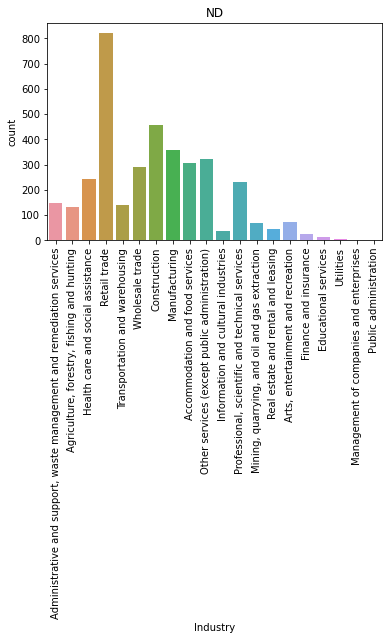

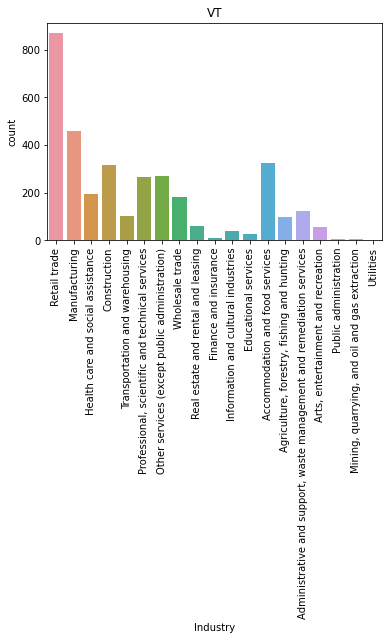

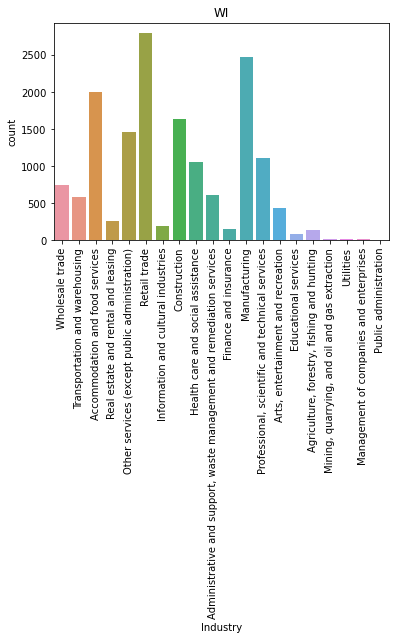

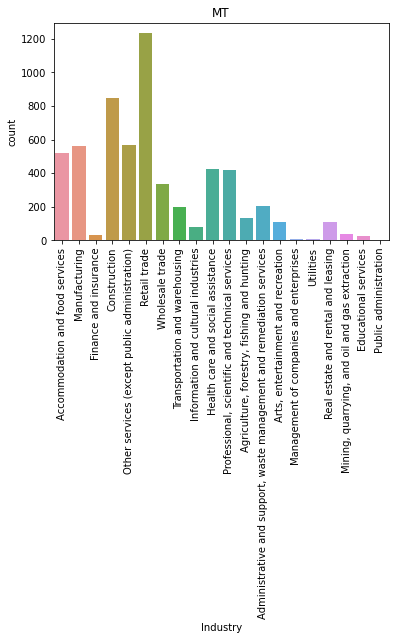

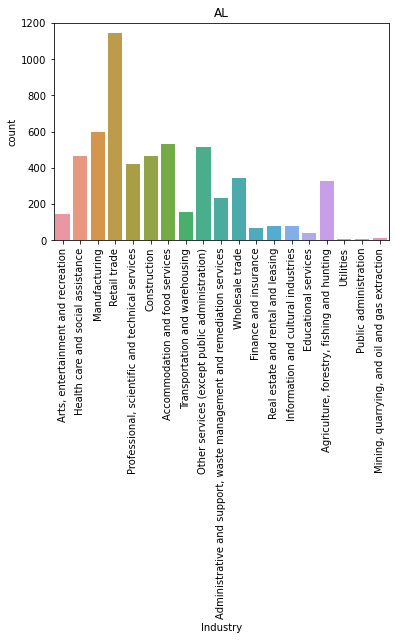

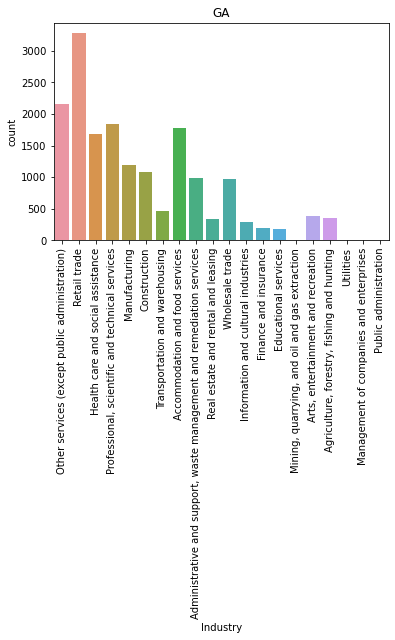

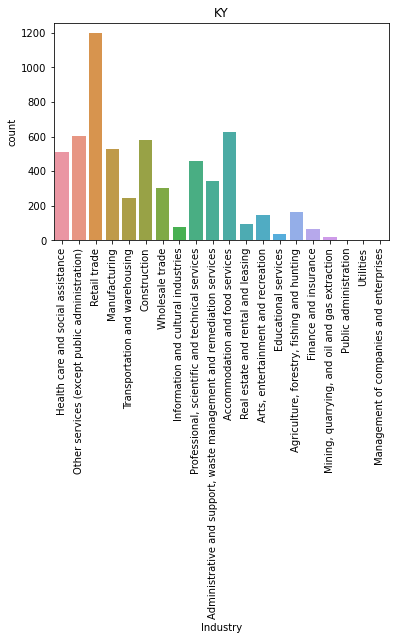

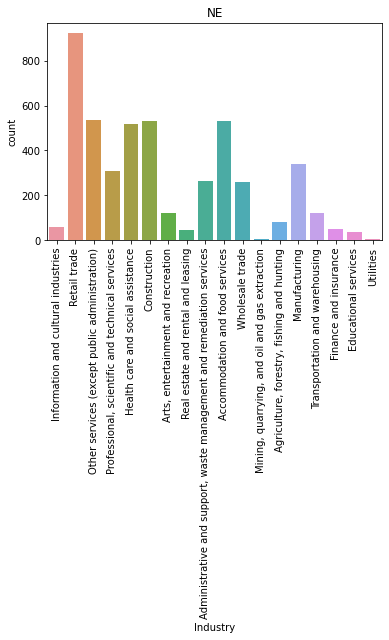

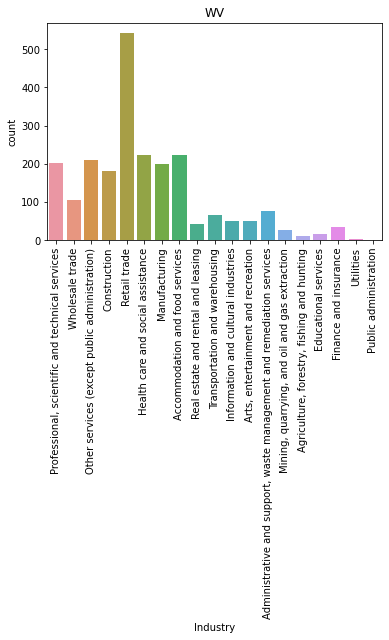

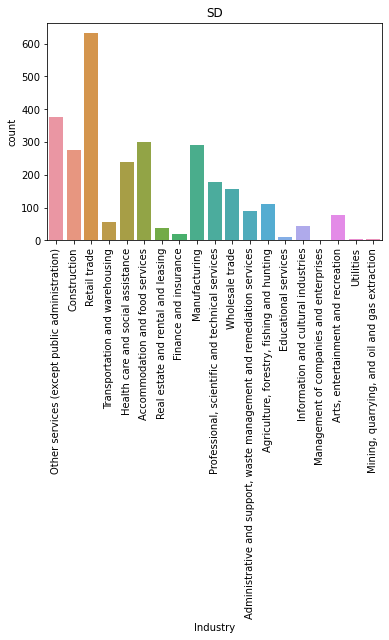

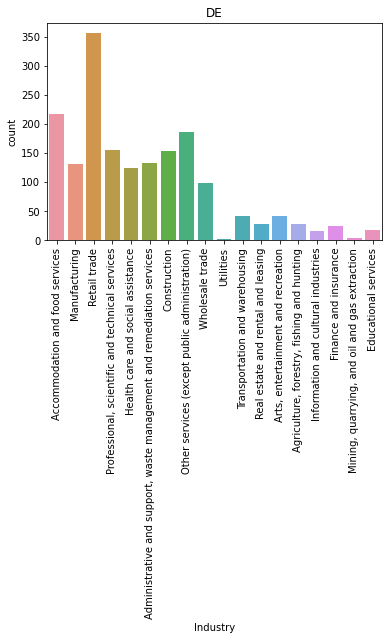

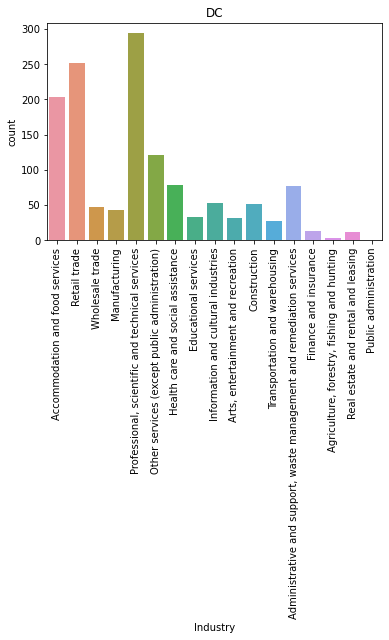

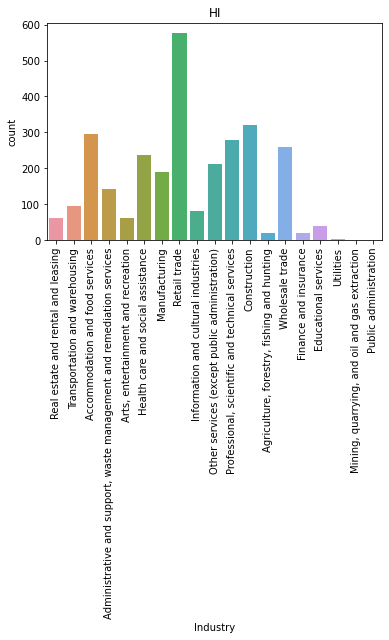

In [61]:
#visuailization, looks like there is a wide distribution of industry in every state, explore other means to fill missing industry data
for state in States_list:
    plt.figure()
    df = No_missing_industry_df[No_missing_industry_df['State'] == state]
    ax = sns.countplot(x="Industry", data=df)
    plt.xticks(rotation='vertical')
    plt.title(state)
    # Show/save figure as desired.

#plt.show()

In [85]:
#Alternatively, maybe the business name can be used to predict the industry that it is in, for example, if a company has 'manufacturing' in the name, it is probably in the manufacturing industry
print(No_missing_industry_df.info())
print(No_missing_industry_df['Name'])



<class 'pandas.core.frame.DataFrame'>
Int64Index: 697197 entries, 0 to 899161
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      697197 non-null  int64  
 1   Name               697197 non-null  object 
 2   City               697197 non-null  object 
 3   State              697197 non-null  object 
 4   Zip                697197 non-null  int64  
 5   Bank               696575 non-null  object 
 6   BankState          696572 non-null  object 
 7   NAICS              697197 non-null  int64  
 8   ApprovalDate       697197 non-null  object 
 9   ApprovalFY         697197 non-null  object 
 10  Term               697197 non-null  int64  
 11  NoEmp              697197 non-null  int64  
 12  NewExist           697061 non-null  float64
 13  CreateJob          697197 non-null  int64  
 14  RetainedJob        697197 non-null  int64  
 15  FranchiseCode      697197 non-null  int64  
 16  Ur

In [110]:
#step 1, split data set to train and test
No_missing_industry_df = No_missing_industry_df.set_index('LoanNr_ChkDgt')
train, test = train_test_split(No_missing_industry_df, test_size=0.2, random_state=0, stratify=No_missing_industry_df['Industry'])
print(train.shape[0])
print(test.shape[0])

557757
139440


In [111]:
#step 2, get the most common keywords that will be used as features for each industry
def find_n_most_common_words(df,industry,n=100):

    df = df.copy()
    df = df[df['Industry'] == industry]
    #parse name column to workable format
    df['Name'] = df['Name'].str.lower()
    df['Name'] = df['Name'].str.replace(',',' ')
    df['Name'] = df['Name'].str.replace('.',' ')
    df['Name'] = df['Name'].str.split(' ') #convert string to a list of words


    list_of_all_words = [item for sublist in df['Name'] for item in sublist]

    new_df = pd.DataFrame(list_of_all_words,columns = ['words'])
    new_df_groupped = new_df.groupby(['words'])['words'].count().sort_values(ascending = False)
    most_common_words = new_df_groupped.index.to_list()[0:n]

    return most_common_words
print(find_n_most_common_words(train,'Educational services')) #try this for Educations service industry, looks good
print(find_n_most_common_words(train,'Manufacturing')) #some makes sense, many are random

['', 'inc', 'llc', 'of', 'school', 'center', 'academy', 'learning', 'dance', 'the', '&', 'dba', 'arts', 'l', 'and', 'training', 'institute', 'a', 'gymnastics', 'martial', 'in', 'enterprises', 'driving', 'montessori', 'college', 'studio', 'services', 'music', 'education', 'huntington', 'c', 'sylvan', 'i', 'international', 'karate', 'educational', 'yoga', 'new', 'group', 'for', 'solutions', 'associates', 'consulting', 'art', 'tutoring', 'sports', 'j', 'computer', 'beauty', 'kids', 'american', 's', 'aviation', 'fitness', 'club', 'd', 'll', 'tae', 'language', 'career', 'm', 'corp', 'golf', 'do', 'professional', 'gym', 'to', 'elite', 'world', 'taekwondo', 'company', 'corporation', 'little', 'studios', 'ltd', 'california', 'cheer', 'systems', 'kwon', 'r', 'business', 'centers', 't', 'schools', 'young', 'health', 'technologies', 'e', 'usa', 'unlimited', 'service', 'technology', 'management', 'valley', 'co', 'all', 'massage', 'creative', 'development', 'south']
['', 'inc', 'llc', '&', 'company

In [112]:
#Step 3, from step 2 there seems to be a lot of overlapping words between different industries, the next step would be eliminating the overlapping words
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3



list_of_words= find_n_most_common_words(train,'Manufacturing')

for industry in list_of_industry:
    industry_words = find_n_most_common_words(train,industry)
    list_of_words = intersection(industry_words,list_of_words)

print(list_of_words)  #['', 'inc', 'llc', 'l', '&', 'c', 'enterprises', 'j', 'and', 'r', 'of', 'm', 'd', 'a'] is the overlapping words, so remove them from the list of most used words



['', 'inc', 'llc', 'l', '&', 'c', 'enterprises', 'j', 'and', 'r', 'of', 'm', 'd', 'a']


In [118]:
#Step 4 Train 19 models to predict 20 industries,
def word_detector(words, texts):

    """
    Copied from Assignment 8
    Returns a DataFrame with detections of words.

    Parameters:
        words (list): A list of words to look for.
        texts (Series): A series of strings to search in.

    Returns:
        (DataFrame): A DataFrame with len(words) columns and texts.shape[0] rows.
    """


    row_to_df = []
    for index, value in texts.items():
        row = [0]*len(words)
        for y in range(len(words)):
            n = 0
            if words[y] in value:
                n = 1
            row[y] = n
        row_to_df.append(row)
    df = pd.DataFrame(row_to_df,columns=words)
    df = df.set_index(texts.index)
    return df

#for industry in list_of_industry:
 #   industry_name_words = find_n_most_common_words(train,industry)
 #    industry_name_words_revised = [item for item in industry_name_words if item not in list_of_words]
  #  x_train = word_detector(industry_name_words,train['Name'])


industry_name_words = find_n_most_common_words(train,'Manufacturing')
industry_name_words_revised = [item for item in industry_name_words if item not in list_of_words] #filter out the overlapping words
industry_name_words_revised = [item for item in industry_name_words_revised if len(item)>1] #further filter out words that has only 1 characters
x_train = word_detector(industry_name_words_revised,train['Name'])
x_train

,inc,llc,company,co,and,products,manufacturing,industries,corporation,corp,...,creative,lab,marble,mountain,fabricators,pallet,finishing,coating,by,welding
LoanNr_ChkDgt,,,,,,,,,,,,,,,,,,,,,
3809285003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6799084005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7285374006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3737774001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6345704007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700805001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1226995003,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2578506001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,company,co,products,manufacturing,industries,corporation,corp,the,printing,machine,...,creative,lab,marble,mountain,fabricators,pallet,finishing,coating,by,welding
LoanNr_ChkDgt,,,,,,,,,,,,,,,,,,,,,
3809285003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6799084005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7285374006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3737774001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6345704007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700805001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1226995003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2578506001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
industry_name_words_revised

['company',
 'co',
 'products',
 'manufacturing',
 'industries',
 'corporation',
 'corp',
 'the',
 'printing',
 'machine',
 'systems',
 'dba',
 'custom',
 'design',
 'in',
 'metal',
 'tool',
 'international',
 'technologies',
 'precision',
 'services',
 'group',
 'ltd',
 'bakery',
 'dental',
 'american',
 'graphics',
 'engineering',
 'steel',
 'solutions',
 'technology',
 'mfg',
 'works',
 'service',
 'designs',
 'machining',
 'plastics',
 'press',
 'wood',
 'industrial',
 'sign',
 'signs',
 'glass',
 'supply',
 'incorporated',
 'advanced',
 'equipment',
 'quality',
 'fabrication',
 'packaging',
 'cabinets',
 'tech',
 'associates',
 'foods',
 'new',
 'print',
 'furniture',
 'shop',
 'valley',
 'usa',
 'west',
 'ice',
 'stone',
 'concrete',
 'die',
 'creative',
 'lab',
 'marble',
 'mountain',
 'fabricators',
 'pallet',
 'finishing',
 'coating',
 'by',
 'welding']